# CIS 545 Homework 2

For this assignment, we will focus on introducing you to hierarchical data stored in dataframes, graph data and traversing relationships among data. you will learn to use pandasql (cause Pandas are the our favorite animal and data science tool 🐼) and Spark. You will be using spark locally and not really on a cluster for this homework. The next homework will unleash the full power of Spark by deploying it on a cluster.

For the second section of assignment, we will focus on graph data.  Many real-world datasets are, or can be modeled by, graphs (or trees which are special cases of graphs).  Examples include:

* Networks (social networks, the Web, the connectome, the Internet, traffic networks, …)
* Sets of data in which some of the data is more closely connected than other parts of the data (edges may represent weighted similarity or affinity)
* Phylogenetic trees, grammars, etc.

### Libraries and Setup Jargon!
Run the following  cells to setup the notebook. When prompted for a selection, select the number that is associated with java 8

In [1]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u242-b08-0ubuntu3~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 106 not upgraded.
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
* 2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2


VERY IMPORTANT : Enter your **8 digit Penn ID** in the student id field below

# Section 1: Stack Exchange Data

## Exploring the Stack Exchange dataset

<img src = "https://cdn.sstatic.net/Sites/stackoverflow/company/img/logos/se/se-logo.png?v=dd7153fcc7fa" width= "600" align ="center"/>

To survive as a student at Penn , you've certainly used Stack Exchange or Stack Overflow, as a source for all your technical queries. Stack Exchange looks a lot like a social network, it has the following pieces of information to tie it all together:


*   Users: All stack exchange users including admins etc. Sad little Penn students are included here.

*   Posts: The questions the users post and any follow ups

*   Comments: As the name suggests, these are comments on posts

*   Votes: Up/Downvotes 

*   Badges: Rewards you earn for being a good samaritan on the stack exchange platform.


For this homework we'll be parsing this data (dumped in XML) into dataframes and relations, and then exploring how to query and assemble the tables into results.  You'll get to exercise your skills in Pandas, SQL, and even something called PandaSQL!

### Dataset Source

We are going to use the XML dataset available at 
[StackExchange Dataset](https://archive.org/details/stackexchange).  

In [0]:
### Install required packages
%%capture
!pip3 install lxml
!pip install pandasql
!pip install googledrivedownloader

In [6]:
import numpy as np
import pandas as pd
import matplotlib

import gc
import time
import warnings

import json # JSON parsing
from lxml import etree # HTML parsing
import time # Time conversions
from lxml import etree # XML Parser
import pandasql as ps #SQL on Pandas Dataframe

import nltk
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Part 1: Steps to load data from Google Drive


We have provided a copy of the "Data Science Stack Exchange" data, which we thought might provide some interesting insights about the very field you are studying!

This is shared in Google Drive because it's (relatively) fast and inexpensive to copy data from GDrive to Colab.  There are multiple files:

* Users.xml:  these are the users of Stack Exchange, including profile info.
* Posts.xml:  these are the posts to Stack Exchange made by users.
* PostHistory.xml: history of posts.
* PostLinks.xml: hyperlinks from posts.
* Comments.xml:  users make comments on posts.
* Tags.xml:  posts can be marked with *tags* such as "regression".
* Votes.xml:  posts can earn votes.
* Badges.xml:  these are the "badges" earned by individual users.




### 1.1 Loading Badges.xml
*  The Badges.xml file has been made public for the access of anyone with a valid Penn email address.
* Running the below cell will download the Badges.xml file into your drive. 
* You will be able to access the file with path as '***/content/Badges.xml***'

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='18B966b7hlwjgNmVUeQASuXTC52czZHxm',
                                    dest_path='/content/Badges.xml')

In [0]:
#TODO
badge_list=[]
tree=etree.parse('Badges.xml')
root=tree.getroot()

for child in root:
  badge_list.append(dict(child.attrib))

In [0]:
badges_df=pd.DataFrame(badge_list)

In [0]:
badges_df['Id']=badges_df['Id'].astype(int)
badges_df['UserId']=badges_df['UserId'].astype(int)
badges_df['Name']=badges_df['Name'].astype(str)
badges_df['Date']=badges_df['Date'].astype(str)
badges_df['Class']=badges_df['Class'].astype(int)
badges_df['TagBased']=badges_df['TagBased'].astype(bool)

### 1.2 Loading Users.xml
*  The Users.xml file has been made public for the access of anyone with a valid UPenn email address.
* Running the below cell will download the Users.xml file into your drive. 
* You will be able to access the file with path as '***/content/Users.xml***'

In [0]:
gdd.download_file_from_google_drive(file_id='1T-SGFULQIkpg6LN5XLhBfiXhcAWNgCLe',
                                    dest_path='/content/Users.xml')

In [0]:
#TODO
users_list=[]
tree=etree.parse('Users.xml')
root=tree.getroot()

for child in root:
  users_list.append(dict(child.attrib))

users_df=pd.DataFrame(users_list)

In [0]:
users_df['Id']=users_df['Id'].astype(int)
users_df['Reputation']=users_df['Reputation'].astype(int)
users_df['DisplayName']=users_df['DisplayName'].astype(str)
users_df['CreationDate']=users_df['CreationDate'].astype(str)
users_df['LastAccessDate']=users_df['LastAccessDate'].astype(str)
users_df['WebsiteUrl']=users_df['WebsiteUrl'].astype(str)
users_df['Location']=users_df['Location'].astype(str)
users_df['AboutMe']=users_df['AboutMe'].astype(str)
users_df['Views']=users_df['Views'].astype(int)
users_df['UpVotes']=users_df['UpVotes'].astype(int)
users_df['DownVotes']=users_df['DownVotes'].astype(int)
#users_df['AccountId']=users_df['AccountId'].astype(int)
users_df['ProfileImageUrl']=users_df['ProfileImageUrl'].astype(str)

### 1.3 Loading Posts.xml
*  The Posts.xml file has been made public for the access of anyone with a valid UPenn email address.
* Running the below cell will download the Posts.xml file into your drive. 
* You will be able to access the file with path as '***/content/Posts.xml***'

In [0]:
gdd.download_file_from_google_drive(file_id='1etuY-EjzgEfMdPCSd7NblNz0qJJpAH3b',
                                    dest_path='/content/Posts.xml')

In [0]:
#TODO
posts_list=[]
tree=etree.parse('Posts.xml')
root=tree.getroot()

for child in root:
  posts_list.append(dict(child.attrib))

posts_df=pd.DataFrame(posts_list)

In [0]:
posts_df['Id']=posts_df['Id'].astype(int)
posts_df['FavoriteCount']=posts_df['FavoriteCount'].astype(str).replace('nan',0).astype(int)
posts_df['ViewCount']=posts_df['ViewCount'].astype(str).replace('nan',0).astype(int)
posts_df['Score']=posts_df['Score'].astype(str).replace('nan',0).astype(int)
posts_df['Body']=posts_df['Body'].astype(str)
posts_df['Title']=posts_df['Title'].astype(str)

### 1.4 Loading Comments.xml
*  The Comments.xml file has been made public for the access of anyone with a valid UPenn email address.
* Running the below cell will download the Comments.xml file into your drive. 
* You will be able to access the file with path as '***/content/Comments.xml***'

In [0]:
gdd.download_file_from_google_drive(file_id='1H7-P3PK7OkPCzk7eK32uYBR42cBL6HIu',
                                    dest_path='/content/Comments.xml')

In [0]:
#TODO
comments_list=[]
tree=etree.parse('Comments.xml')
root=tree.getroot()

for child in root:
  comments_list.append(dict(child.attrib))

comments_df=pd.DataFrame(comments_list)

In [0]:
comments_df['Id']=comments_df['Id'].astype(int)
comments_df['PostId']=comments_df['PostId'].astype(int)
#comments_df['UserId']=comments_df['UserId'].astype(int)
comments_df['Score']=comments_df['Score'].astype(int)
comments_df['Text']=comments_df['Text'].astype(str)
comments_df['CreationDate']=comments_df['CreationDate'].astype(str)

## Part 2: Exploring the data

***'pandasql'*** allows you to query pandas DataFrames using SQL syntax. It works similarly to sqldf in R. pandasql seeks to provide a more familiar way of manipulating and cleaning data for people new to Python or pandas. Lets use *pandasql* to work on few queries. For those interested, [here](https://community.alteryx.com/t5/Data-Science-Blog/pandasql-Make-python-speak-SQL/ba-p/138435) is a good resource for pandasql (obviously there are many others)

### 2.1 Credible Users
Let's first find credible users (i.e. not Craig) who have a reputation of >= 5000. Reputation reflects a users familiarity with the site and the expected quality of the content they provide. It also affects the amount of privileges the user has within the Stack Exchange system. Users gain or lose reputation based on the quality of their interactions with the system and other community members. The primary reason for reputation change is voting. Posts which are voted up increase their authors’ reputation; the reverse is true for posts which are voted down. 

For example: If you are rude to TAs or his majesty, your reputation drops by -100000.

You can read more about it [here](https://meta.stackexchange.com/questions/7237/how-does-reputation-work)!


TLDR : Your task is to print the names of the users who have a reputation greater than or equal to 5,000 in the decreasing order of their reputation i.e. highest reputation first


In [0]:
#TODO
credible_user_names='''SELECT DisplayName,Reputation FROM users_df WHERE Reputation>=5000 ORDER BY Reputation DESC'''
credible_user_names_df=ps.sqldf(credible_user_names,locals())

### 2.2 The Talkative Ten (i.e. the Maggies)

Find the names of the top 10 users who post the most on stack exchange in the decreasing order of their number of posts. 

Your result dataframe should contain both names and the corresponding number of posts.

In [0]:
#TODO
talkative_users='''SELECT u.DisplayName, COUNT(*) AS POST_COUNT FROM posts_df AS p
                      JOIN users_df AS u ON u.Id=p.OwnerUserId
                        GROUP BY p.OwnerUserId ORDER BY POST_COUNT DESC
                          LIMIT 10'''
talkative_users_df=ps.sqldf(talkative_users,locals())

### 2.3 The Fabulous favorites (i.e. the Prof Ives)

On stack exchange you can favourite posts which allows you to easily access them kinda like the liked songs on spotify. Find the top 5% most favorited posts. 

Return the id, text, and number of favorites, in the decreasing order of the number of favorites. Your result schema should be: Id, Body, TOP_MOST

In [0]:
#TODO
favorited_post='''SELECT Id, Body, FavoriteCount AS TOP_MOST FROM posts_df ORDER BY TOP_MOST DESC
                LIMIT ROUND((SELECT COUNT(*) FROM posts_df)*0.05)'''
answer_df=ps.sqldf(favorited_post,locals())

### 2.4 Where the data scientists at? 

We hypothesize that most data science posts come from Silicon Valley (the place, not the TV show). We will compare the number of posts from users in  silicon valley to the number of posts from the users (mostly sad Penn engineering students) in Philadelphia. 

First, create a dataframe to find out posts of all users who are based out of Silicon Valley(location contains the word "Silicon Valley"). The dataframe should contain the user's display name and the content(the body) of the post. Name the second column "SILICON_POSTS" and do this within the query.

In [0]:
#TODO
silicon_posts='''SELECT u.DisplayName, p.Body AS SILICON_POSTS FROM posts_df AS p
                      JOIN users_df AS u ON u.Id=p.OwnerUserId
                          WHERE u.Location LIKE '%Silicon Valley%'
                          '''
silicon_posts_df=ps.sqldf(silicon_posts,locals())

Now let's find the number of posts from Philly! Create a similar dataframe as above but for location as Philadelphia

In [0]:
#TODO
cheesesteak_posts='''SELECT u.DisplayName AS DisplayName, p.Body AS PHILADELPHIA_POSTS FROM posts_df AS p
                      JOIN users_df AS u ON u.Id=p.OwnerUserId
                          WHERE u.Location LIKE '%Philadelphia%'
                          '''
cheesesteak_posts_df=ps.sqldf(cheesesteak_posts,locals())

Next, find the locations whose users make the most number of posts. You should return a dataframe with the location and the corresponding number of posts. Title the second column "NUM_POSTS". Do this within the query. Limit your results to only 25

In [0]:
#TODO
locations_post_count='''SELECT u.Location, COUNT(*) AS NUM_POSTS FROM posts_df AS p
                  JOIN users_df AS u ON u.Id=p.OwnerUserId
                      GROUP BY u.Location ORDER BY NUM_POSTS DESC LIMIT 25
                      '''
locations_post_count_df=ps.sqldf(locations_post_count,locals())

### 2.5 The Self-Obsessed Users (i.e. the Craigs again)

Let's find users who comment on their own posts a lotttt. You should return a dataframe which has the display name of the user and the number of comments that the person has on their own posts. 
Keep users whose number of comments (on their own posts) is strictly greater than the median number from your result

In [0]:
#TODO
self_obsessed='''SELECT co.UserId AS UserId, COUNT(*) AS Count FROM comments_df AS co
                  JOIN posts_df AS p ON co.PostId=p.Id
                    WHERE UserId=p.OwnerUserId GROUP BY UserId
                    HAVING Count>1 ORDER BY Count DESC
                    '''
filter_df=ps.sqldf(self_obsessed,locals())

### 2.6 All about the 'Big Data' Buzz

You probably signed up for this class for the cooool name 'bIg DaTa ANalYtIcS'. Big data and ML are the current hype. Let's see how many posts talk about big data and how often these are viewed. 

Create a dataframe that includes the title, view count and body where the post body contains 'big data' (ignore case when you match). Sort in the decreasing order of the number of views. Return only posts which have been viewed.


In [0]:
#TODO
buzz='''SELECT Title, ViewCount, Body FROM posts_df 
              WHERE UPPER(Body) LIKE '%BIG DATA%' AND ViewCount>0 
                ORDER BY ViewCount DESC'''
buzz_df=ps.sqldf(buzz,locals())

Next, fetch the authors(displayName) of the top 10 posts in the buzz_df created above. Return the authors in the decreasing order of the view counts of their corresponding posts. Your dataframe should include the display name and the view count for the corresponding post.


In [0]:
#TODO
buzz_authors='''SELECT u.DisplayName AS DisplayName, b.ViewCount AS ViewCount FROM buzz_df AS b
            JOIN posts_df AS p ON p.Title=b.Title 
              JOIN users_df AS u ON u.ID=p.OwnerUserId
                ORDER BY ViewCount DESC LIMIT 10
                '''
buzz_authors_df=ps.sqldf(buzz_authors,locals())

## Part 3: Working with Text Data

Our Stack Exchange data has plenty of text that we can play with, from the user descriptions, to the posts themselves. Text data is complex, but can also be generate extremely interpretable results, making it valuable and interesting. 

Let's see how we can apply the concepts from lecture to this dataset.

***You should revert to using pandas to handle the data in this section, rather than pandasql.***

### How do I get a high score? 

Suppose you're very invested in your Stack Exchange reputation, so you want to figure out what to post to increase your own reputation. Each post receives a score, where **score = number of upvotes - number of downvotes**. This value is already present in your posts_df. 

So, what should you post about in order to get a higher score and thus a higher reputation? Additionally, what shouldn't you post about?


### 3.1
First, get the the top 2% and the bottom 2% of posts in the dataset, by **Score**.

Create two separate dataframes and name them **highest_scorers** and **lowest_scorers**.

In [0]:
num=int(len(posts_df)*0.02)

In [0]:
#TODO
lowest_scorers=posts_df.sort_values(by='Score',ascending=True)[:num]
highest_scorers=posts_df.sort_values(by='Score',ascending=False)[:num]

### 3.2 

Next, generate a list of tokens from the highest_scorers and the lowest_scorers. 

There are a few ways you can go about doing this, so you're welcome to take your own approach (as long as it still generates the same result!). Take a look at the notebook from the Text Lecture for some guidance!

Here is a method that you could use:

For each dataframe: 
1. Create a list of all of the titles. 
2. Tokenize each of the titles.
3. Flatten into one single list of tokens.

**Important:** Make sure you do the following:
- Remove any posts without a title, aka with a 0 where the title should be. 
- Lowercase all of the words.


In [0]:
import nltk
from nltk.tokenize import word_tokenize

In [0]:
#TODO
def get_token_list(scorers):
  title_list=[]
  for index, row in scorers.iterrows():
    if row['Title']!='nan':
      title_list.append(row['Title'])

  word_list=[]
  for title in title_list:
    words = word_tokenize(str(title))
    for word in words:
      if word.isalpha():
        word_list.append(word.lower())
  return word_list

In [0]:
lowest_tokens=get_token_list(lowest_scorers)
highest_tokens=get_token_list(highest_scorers)

### 3.3 
Next, we should remove stopwords from these lists. 

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

When processing text, we want to exclude these words, otherwise they will dilute our results. We do not want them to take up space or processing time, or to have to filter through them when reading our results.

Fortunately, the NLTK package has a predefined list of stopwords that we can utilize.

In [49]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop_words = set(stopwords.words('english')) 

In [0]:
stop_words=list(stop_words)

Take a look at some of the stop words to familiarize yourself with the concept.

Filter all of these stopwords out of both our lists of tokens.

In [0]:
#TODO
def get_filtered_words(tokens):
  filtered_words=[]
  for word in tokens:
    if word not in stop_words:
      if word!='nan':
        filtered_words.append(word)
  return filtered_words

In [0]:
filtered_lowest=get_filtered_words(lowest_tokens)
filtered_highest=get_filtered_words(highest_tokens)

Now, find the 20 most common words amongst your highest scoring titles and your lowest scoring titles.

In [0]:
#TODO
def count_word(filtered):
  cnt = Counter()
  for word in filtered:
    cnt[word] += 1

  counter_df = pd.DataFrame.from_dict(cnt,orient='index').reset_index()
  counter_df_sorted = counter_df.sort_values(by=0,ascending=False)[:20]
  return counter_df_sorted

In [0]:
lowest_counter_df=count_word(filtered_lowest)
highest_counter_df=count_word(filtered_highest)

In [0]:
lowest_counter=lowest_counter_df['index'].values.tolist()
highest_counter=highest_counter_df['index'].values.tolist()

### 3.4

Oof. Well, these words look pretty much the same... 

Let's visualize our results in word clouds and see if we can notice any significant takeaways.

Create two word clouds- one of each group of tokens that you generated. Title them so that it is clear which visualization corresponds to which group.

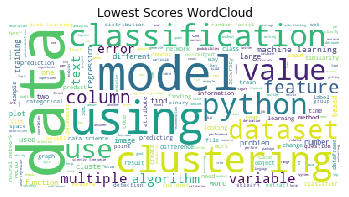

In [59]:
#TODO
wordcloud=WordCloud(background_color='white').generate(" ".join(filtered_lowest))                        
plt.title('Lowest Scores WordCloud')
plt.axis("off")
plt.imshow(wordcloud)

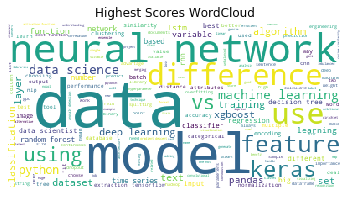

In [60]:
wordcloud=WordCloud(background_color='white').generate(" ".join(filtered_highest))                        
plt.title('Highest Scores WordCloud')
plt.axis("off")
plt.imshow(wordcloud)

# Section 2: Spark, Hierarchical Data and Graph Data on Yelp Reviews Dataset

## Getting Started with Apache Spark

Apache Spark, which has become the de facto successor to Apache Hadoop, is a complex, cluster-based data processing system that was written in Scala.  It leverages a wide variety of distributed tools and components used for big data processing.  It interfaces “smoothly” to Python, but be forewarned that there are some rough edges.  For those interested in why, there are a few reasons:

* Scala has slightly different notions of types (especially things like Rows) and handles missing values (nulls) differently from Python.
* The Scala-based Spark “engine” can’t just run Python functions as it’s doing data processing.  This means that you want to be careful to use Spark’s library of functions, or the special mechanisms for inserting “user defined functions.”
* DataFrames on Spark are “sharded,” so there is no single object corresponding to the DataFrame!

While Spark DataFrames try to emulate the same programming style as Pandas DataFrames, there are some differences in how you express things.  Please refer to the Lecture Slides for our take on the differences.  You may also find the following Web pages to be useful resources for understanding Spark vs Pandas DataFrames:

https://lab.getbase.com/pandarize-spark-dataframes/
https://ogirardot.wordpress.com/2015/07/31/from-pandas-to-apache-sparks-dataframe/ 

For this assignment, we are going to get familiar with Spark without worrying too much about sharding and distribution.  We are going to run Spark on your Docker container.  This isn’t really using it to its strengths -- and in fact you might find Spark to be unexpectedly slow -- but it will get you comfortable with programming in Spark without worrying about distributed nodes, clusters, and spending real dollars on the cloud.  Your code, if written properly, will “naturally scale” to clusters running on the Cloud.  Later in the term we’ll connect your Jupyter instance to Spark running on the cloud -- to handle “truly big data.”


### Initializing a Connection to Spark

We'll open a connection to Spark as follows. Note that Spark has multiple interfaces, as you will see if you look at sample code elsewhere. `SparkSession` is the “most modern” one and we’ll be using it for this course.  From `SparkSession`, you can load data into Spark DataFrames as well as `RDD`s.

Run the follow cells to setup the notebook!

In [62]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 106 not upgraded.
--2020-02-23 22:10:50--  https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving www-us.apache.org (www-us.apache.org)... 40.79.78.1
Connecting to www-us.apache.org (www-us.apache.org)|40.79.78.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz [following]
--2020-02-23 22:10:50--  https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 2a01:4f8:10a:201a::2
Connecting to downloads.apache.org (downloads.apache

In [63]:
!apt update
!apt install gcc python-dev libkrb5-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (124 kB/s)
Reading package lists... Done
Building dependency tree       
Reading s

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()


In [0]:
%load_ext sparkmagic.magics

In [0]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter

# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [0]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


### Download data

The following code retrieves the Yelp dataset files from Google Drive.

In [0]:
!rm -rf yelp_*

In [69]:
!wget https://upenn-bigdataanalytics.s3.amazonaws.com/data/yelp_business.csv
!wget https://upenn-bigdataanalytics.s3.amazonaws.com/data/yelp_review2.csv
!wget https://upenn-bigdataanalytics.s3.amazonaws.com/data/yelp_business_attributes.csv
!wget https://upenn-bigdataanalytics.s3.amazonaws.com/data/yelp_checkin.csv
!wget https://upenn-bigdataanalytics.s3.amazonaws.com/data/yelp_user.csv

--2020-02-23 22:11:41--  https://upenn-bigdataanalytics.s3.amazonaws.com/data/yelp_business.csv
Resolving upenn-bigdataanalytics.s3.amazonaws.com (upenn-bigdataanalytics.s3.amazonaws.com)... 52.216.99.187
Connecting to upenn-bigdataanalytics.s3.amazonaws.com (upenn-bigdataanalytics.s3.amazonaws.com)|52.216.99.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30364138 (29M) [text/csv]
Saving to: ‘yelp_business.csv’

yelp_business.csv   100%[===================>]  28.96M   102MB/s    in 0.3s    

2020-02-23 22:11:41 (102 MB/s) - ‘yelp_business.csv’ saved [30364138/30364138]

--2020-02-23 22:11:42--  https://upenn-bigdataanalytics.s3.amazonaws.com/data/yelp_review2.csv
Resolving upenn-bigdataanalytics.s3.amazonaws.com (upenn-bigdataanalytics.s3.amazonaws.com)... 52.216.84.147
Connecting to upenn-bigdataanalytics.s3.amazonaws.com (upenn-bigdataanalytics.s3.amazonaws.com)|52.216.84.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3791

## Part 4:

### 4.1 Load Our Graph Datasets.

For this assignment, we’ll be looking at graph data (reviews, reviewers, businesses) downloaded from Yelp.

Let’s read our social graph data from Yelp, which forms a directed graph.  Here, the set of nodes is also not specified; the assumption is that the only nodes that matter are linked to other nodes, and thus their IDs will appear in the set of edges.  To load the file `input.txt` into a Spark DataFrame, you can use lines like the following.

```
# Read lines from the text file
input_sdf = spark.read.load('input.txt', format="text")
```

We’ll use the suffix `_sdf` to represent “Spark DataFrame,” much as we used `_df` to denote a Pandas DataFrame in Homework 1.  Load the various files from Yelp.

Your datasets should be named `yelp_business_sdf`, `yelp_business_attributes_sdf`, `yelp_check_in_sdf`, `yelp_reviews_sdf`, and `yelp_users_sdf`.

Submit the first 75 entries of the yelp_business_sdf to the autograder as a pandas dataframe by using the toPandas() function to convert it from a spark dataframe to a normal dataframe. Also,
 make sure to sort it by the "name" column in ascending order

In [0]:
#TODO
yelp_business_sdf=spark.read.format('csv').option('header','true').load('yelp_business.csv')
yelp_business=yelp_business_sdf.toPandas().sort_values(by='name',ascending=True)

In [0]:
#TODO
yelp_business_sdf.createOrReplaceTempView('yelp_business')

### 4.2 Simple Analytics on the Data

In this section, we shall be executing Spark operations on the data given. Beyond simply executing the queries, you may try using `.explain()` method to see more about the query execution. Also, please read the data description prior to attempting the following questions to understand the data.


Compute, stored in `best_average_sdf`, the list of names of businesses based on their average review score (review stars), in decreasing order, sorted lexicographically (in increasing order) by name if they have the same score.  Output the number of reviews also.  Call the columns `name`, `avg_rating`, and `count`.

Convert this to pandas and submit the first 75 rows 

In [0]:
#TODO
best_average_sdf=spark.sql('''SELECT name, stars AS avg_rating, review_count AS count 
                      FROM yelp_business ORDER BY avg_rating DESC, name ASC''')

In [0]:
best_average_sdf_75=best_average_sdf.toPandas()[:75]

#### 4.2.1 Users who are more negative than average

Find the users whose average review is below the *average of the per-user* average reviews.  Think about how to factor that into steps!

* Compute the (floating-point) variable `overall_avg` as the average of the users' average reviews. (You might compute this in a Spark DataFrame first).
* Then output `negative_users_sdf` as the users whose average rating is below that.  This Spark dataframe should have `name` and `avg_rating` and should be sorted first (from lowest to highest) by average rating, then lexicographically (in ascending order) by name.  You should drop cases where the name is null.

Submit just the overall_avg number that you get to the autograder as a float


In [0]:
#TODO
yelp_users_sdf=spark.read.format('csv').option('header','true').load('yelp_user.csv')
yelp_users_sdf.createOrReplaceTempView('yelp_users')

In [78]:
overall_avg_sdf=spark.sql('''SELECT AVG(average_stars) FROM yelp_users''')
overall_avg_sdf.show()

+----------------------------------+
|avg(CAST(average_stars AS DOUBLE))|
+----------------------------------+
|                3.7108406832064325|
+----------------------------------+



In [0]:
overall_avg=3.7108406832064325

negative_users_sdf=spark.sql('''SELECT name, average_stars AS avg_rating FROM yelp_users
                    WHERE average_stars<(SELECT AVG(average_stars) FROM yelp_users) 
                        AND name IS NOT NULL ORDER BY avg_rating ASC, name ASC''')

### 4.2.2 Cities by number of businesses

Find the top 10 cities by number of (Yelp-listed) businesses.

This time, use the `take()` function to create a *list* of the top 10 cities (as Rows).  Call this list `top10_cities` and make sure it includes city `name` and `num_restaurants`.

We want to answer as a list of lists where each element is the combination of the city name + num_restaurants:

[["Philadelphia", 12345], ["Los Angeles", 543]]

In [0]:
#TODO
cities_count=yelp_business_sdf.groupBy('city').agg({'city':'count'}).withColumnRenamed('count(city)','num_restaurants').orderBy(['num_restaurants'],ascending=[0])
top10_cities=cities_count.take(10)

In [0]:
final=cities_count.toPandas()[:10].values.tolist()

In [0]:
yelp_reviews_sdf=spark.read.format('csv').option('header','true').load('yelp_review2.csv')
yelp_reviews_sdf.createOrReplaceTempView('yelp_reviews')

In [0]:
review_graph_sdf = spark.sql('''SELECT user_id AS from_node, business_id AS to_node, stars AS score FROM yelp_reviews
                        WHERE business_id IS NOT NULL
                        AND user_id IS NOT NULL''')

review_graph_sdf.createOrReplaceTempView('review_graph')


## Part 5. “Traversing” a Graph

For our next tasks, we will be “walking” the graph and making connections.



Create a function `spark_bfs(G, origins, max_depth)` that takes a Spark DataFrame with a graph G (following the schema for `review_graph_sdf` described above, but to be treated as an **undirected graph**), a Python list-of-dictionaries `origins` of the form 

```
[{‘node’: nid1}, 
 {‘node’: nid2}, 
 …]
```

and a nonnegative integer “exploration depth” `max_depth` (to only run BFS on a tractable portion of the graph).  The `max_depth` will be the maximum number of edge traversals (e.g., the origin is at `max_depth=0`, one hop from the origin is `max_depth=1`, etc.  The function should return a DataFrame containing pairs of the form (node, distance), where the distance is depth at which $n$ was *first* encountered (i.e., the shortest-path distance from the origin nodes).  Note that the origin nodes should also be returned in this Spark DataFrame (with depth 0)!  

You can create a new Spark DataFrame with an integer `node` column from the above list of maps `origins`, as follows. This will give you a DataFrame of the nodes to start the BFS at

```
schema = StructType([
            StructField("node", StringType(), True)
        ])

    my_sdf = spark.createDataFrame(my_list_of_maps, schema)
```

In this algorithm, be careful in each iteration to keep only the nodes with their shortest distances (you may need to do aggregation or item removal).  You should accumulate all nodes at distances 0, 1, ..., `max_depth`.

In [0]:
from pyspark.sql.functions import lit

In [0]:
# TODO: iterative search over undirected graph
def spark_bfs(G,origins,max_depth):
  i=0
  new_nodes=spark.createDataFrame(origins)
  reachable_nodes=new_nodes.withColumn('distance',lit(i))
  G=G.select('from_node','to_node')
  G2=G.withColumnRenamed('to_node','from_node_').withColumnRenamed('from_node','to_node').withColumnRenamed('from_node_','from_node').select('from_node','to_node')
  total_G=G.union(G2)

  while i<max_depth:
    i+=1
    new_nodes=total_G.join(new_nodes,total_G.from_node==new_nodes.node).select(total_G.to_node).distinct().withColumn('distance',lit(i))
    reachable_nodes=reachable_nodes.union(new_nodes)
    new_nodes=new_nodes.withColumnRenamed('to_node','node')

  result_df=reachable_nodes.toPandas().drop_duplicates(subset='node',keep='first')
  
  return result_df

This is the starting origin node ID for your BFS and the associated call

In [88]:
orig = [{'node': 'bv2nCi5Qv5vroFiqKGopiw'}]
#grab the count
count = spark_bfs(review_graph_sdf, orig, 3)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/session.py:346: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"
